In [1]:
%pylab inline
%load_ext autoreload
%autoreload 1

import gc
import numpy as np
from fpfs import simutil
import scipy.ndimage as ndi
import matplotlib.pylab as plt
import astropy.io.fits as pyfits
from fpfs.imgutil import gauss_kernel

import pdet
%aimport pdet
import pltutil

Populating the interactive namespace from numpy and matplotlib
Do not have lsst pipeline!


In [47]:
ishear=1
igroup=1
do_plot=False
ngrid=64
if igroup>=0:
    ngal=100
    img1=pyfits.getdata('../../sim/galaxy_basicCenter_psf60/image-%d-g%d-0000.fits' %(igroup,ishear))
    img2=pyfits.getdata('../../sim/galaxy_basicCenter_psf60/image-%d-g%d-2222.fits' %(igroup,ishear))
else:
    ngal=1
    img1=simutil.make_basic_sim('basicCenter_psf60','g%d-1111' %ishear,0,ny=ngal,nx=ngal,do_write=False)
    img2=simutil.make_basic_sim('basicCenter_psf60','g%d-2222' %ishear,0,ny=ngal,nx=ngal,do_write=False)
ngrid2=ngrid*ngal

# PSF
psf=pyfits.getdata('../../sim/galaxy_basic_psf60/psf-60.fits')
npad       =   (ngrid2-psf.shape[0])//2
psfData    =   np.pad(psf,(npad+1,npad),mode='constant')
assert psfData.shape[0]==ngrid2
psfF=np.fft.fft2(np.fft.ifftshift(psfData))

In [3]:
gsigma=4.*2.*np.pi/64
print(1/gsigma)
gKer,grids=gauss_kernel(ngrid2,ngrid2,gsigma,return_grid=True)
imgF1=np.fft.fft2(img1)/psfF*gKer
imgF2=np.fft.fft2(img2)/psfF*gKer
imgCov1=np.fft.ifft2(imgF1).real
imgCov2=np.fft.ifft2(imgF2).real
gc.collect()

2.5464790894703255


47

In [4]:
indX=np.arange(32,6400,64)
indY=np.arange(32,6400,64)
inds    =   np.meshgrid(indY,indX,indexing='ij')
coords  =   np.array(np.zeros(inds[0].size),dtype=[('pdet_y','i4'),('pdet_x','i4')])
yid=   np.ravel(inds[0])
xid=   np.ravel(inds[1])

10000


30

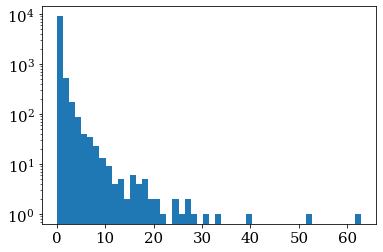

In [5]:
val0=imgCov1[yid,xid]
print(len(val0))
plt.close()
plt.hist(val0,bins=50)
plt.yscale('log')
gc.collect()

12745

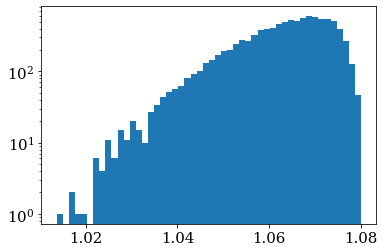

In [7]:
fp= np.array([[0.,1./4,0.],[1./4,0.,1./4],[0.,1./4,0.]])
fimg1  = ndi.convolve(imgCov1,weights=fp,mode='constant')
val1 = fimg1[yid,xid]
plt.close()
plt.hist(val0/val1,bins=50)
plt.yscale('log')
gc.collect()

11751

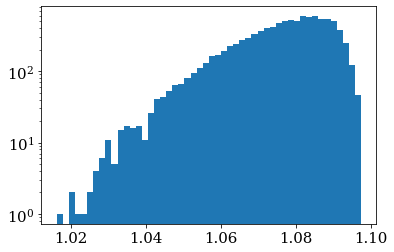

In [8]:
fp= np.array([[1./4,0.,1./4],[0.,0.,0.],[1./4,0.,1./4]])
fimg2  = ndi.convolve(imgCov1,weights=fp,mode='constant')
val2 = fimg2[yid,xid]
plt.close()
plt.hist((val0/5.+val1*4/5.)/val2,bins=50)
plt.yscale('log')
gc.collect()

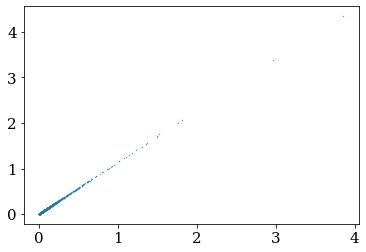

In [42]:
plt.scatter(val0-val1,val0/5.+val1*4./5.-val2,s=0.1)

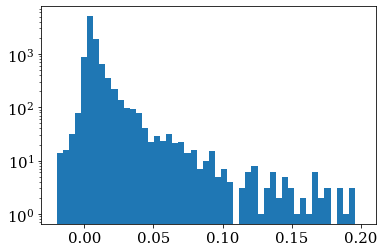

In [10]:
_=plt.hist(val0-val1*1.04,bins=50,range=(-0.02,0.2))
plt.yscale('log')

469894 5910


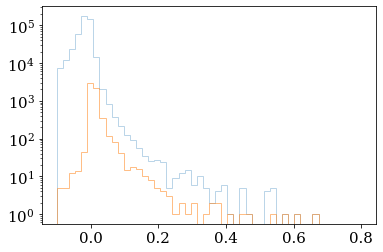

In [33]:
msk1=imgCov1>0.2
mskv1=(val0>0.2)
print(np.sum(msk1),np.sum(mskv1))
plt.close()
plt.hist(imgCov1[msk1]-1.04*fimg1[msk1],bins=50,alpha=0.3,histtype='step',range=(-0.1,0.8))
plt.hist(val0[mskv1]-1.04*val1[mskv1],bins=50,alpha=0.5,histtype='step',range=(-0.1,0.8))
plt.yscale('log')

9872
599


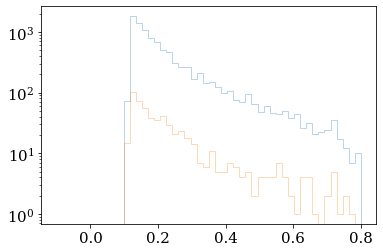

In [41]:
msk2=msk1&((imgCov1-1.00*fimg1)>0.1)
print(np.sum(msk2))
mskv2=mskv1&((val0-1.00*val1)>0.1)
print(np.sum(mskv2))
plt.close()
_=plt.hist((imgCov1[msk2]/5.+fimg1[msk2]*4/5.)-fimg2[msk2],bins=50,alpha=0.3,histtype='step',range=(-0.1,0.8))
_=plt.hist((val0[mskv2]/5.+val1[mskv2]*4/5.)-val2[mskv2],bins=50,alpha=0.3,histtype='step',range=(-0.1,0.8))
plt.yscale('log')

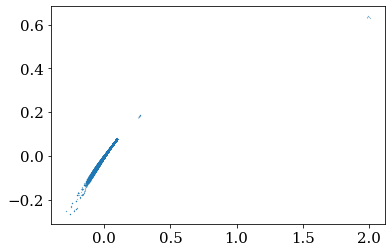

In [45]:
plt.scatter((imgCov1[msk1]/5.+fimg1[msk1]*4/5.-fimg2[msk1])/fimg2[msk1],(imgCov1[msk1]-1.0*fimg1[msk1])/fimg1[msk1],s=0.01)

In [ ]:
%%time
out=pdet.detect_coords(imgCov1,1.)